In [ ]:
!pip install torch torchvision timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 85.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from typing import Tuple
import random
from PIL import Image
import timm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns



# Data loader class that applies data augmentation, change to grayscale and normalize all images in the dataset 1
class CovidDataloader:
    def __init__(self):
        dataset = "Pre_Train"
        self.train_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Train"
        self.val_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Val"
        self.test_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Test"

        def grayscale_to_rgb(image):
            return Image.merge('RGB', (image, image, image))

        self.train_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((224, 224)),
            transforms.Lambda(grayscale_to_rgb),  # USe grayscale values for all 3 channels for train set images

            # Apply data augmentation Random Horizontal and Vetrical Filp, Rotation by 15 degress, translation, scale, shear and normalize the images only in train set
            transforms.RandomApply([
                transforms.RandomRotation(15),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
                transforms.RandomAffine(degrees=0, shear=10)
            ], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.val_test_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((224, 224)),
            transforms.Lambda(grayscale_to_rgb),  # Use grayscale values for all 3 channels for test and validation sets
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.train_dataset = datasets.ImageFolder(root=self.train_dir, transform=self.train_transform)
        self.val_dataset = datasets.ImageFolder(root=self.val_dir, transform=self.val_test_transform)
        self.test_dataset = datasets.ImageFolder(root=self.test_dir, transform=self.val_test_transform)

    def get_loaders(self, batch_size: int = 32, num_workers: int = 2):
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
        val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
        test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

        return train_loader, val_loader, test_loader



dataloader = CovidDataloader()
train_loader, val_loader, test_loader = dataloader.get_loaders(batch_size=64)

print(f"Length of training dataset: {len(dataloader.train_dataset)}")
print(f"Length of validation dataset: {len(dataloader.val_dataset)}")
print(f"Length of test dataset: {len(dataloader.test_dataset)}")


Length of training dataset: 3840
Length of validation dataset: 956
Length of test dataset: 1199


In [ ]:
# Initialize the MViTv2 model with imagenet weights
model = timm.create_model('mvitv2_small', pretrained=True, num_classes=3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/140M [00:00<?, ?B/s]

MultiScaleVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (stages): ModuleList(
    (0): MultiScaleVitStage(
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (pool_q): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
            (norm_q): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_k): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_k): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_v): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_v): LayerN

In [ ]:
# Use the learning rate and weight decay used by the model for its imagenet fine-tuning

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=6.75e-5, weight_decay=0.01)

writer = SummaryWriter()

num_epochs = 10

# Train the model

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch}/{num_epochs - 1}")
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.max(outputs, 1)[1]
        running_corrects += torch.sum(preds == labels.data)


    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = torch.max(outputs, 1)[1]
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)

    writer.add_scalars('Loss', {'train': epoch_loss, 'val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'train': epoch_acc, 'val': val_acc}, epoch)

    print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

writer.close()

Starting epoch 0/9


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0/9, Train Loss: 0.6737, Train Acc: 0.7089, Val Loss: 0.3053, Val Acc: 0.8274
Starting epoch 1/9
Epoch 1/9, Train Loss: 0.3845, Train Acc: 0.8487, Val Loss: 0.2117, Val Acc: 0.8577
Starting epoch 2/9
Epoch 2/9, Train Loss: 0.2887, Train Acc: 0.8844, Val Loss: 0.1900, Val Acc: 0.8661
Starting epoch 3/9
Epoch 3/9, Train Loss: 0.2594, Train Acc: 0.8951, Val Loss: 0.1584, Val Acc: 0.8787
Starting epoch 4/9
Epoch 4/9, Train Loss: 0.2201, Train Acc: 0.9148, Val Loss: 0.1843, Val Acc: 0.8672
Starting epoch 5/9
Epoch 5/9, Train Loss: 0.2043, Train Acc: 0.9216, Val Loss: 0.1526, Val Acc: 0.8713
Starting epoch 6/9
Epoch 6/9, Train Loss: 0.1669, Train Acc: 0.9352, Val Loss: 0.1837, Val Acc: 0.8588
Starting epoch 7/9
Epoch 7/9, Train Loss: 0.1725, Train Acc: 0.9344, Val Loss: 0.1761, Val Acc: 0.8640
Starting epoch 8/9
Epoch 8/9, Train Loss: 0.1411, Train Acc: 0.9479, Val Loss: 0.2472, Val Acc: 0.8609
Starting epoch 9/9
Epoch 9/9, Train Loss: 0.1350, Train Acc: 0.9477, Val Loss: 0.1770, Val A

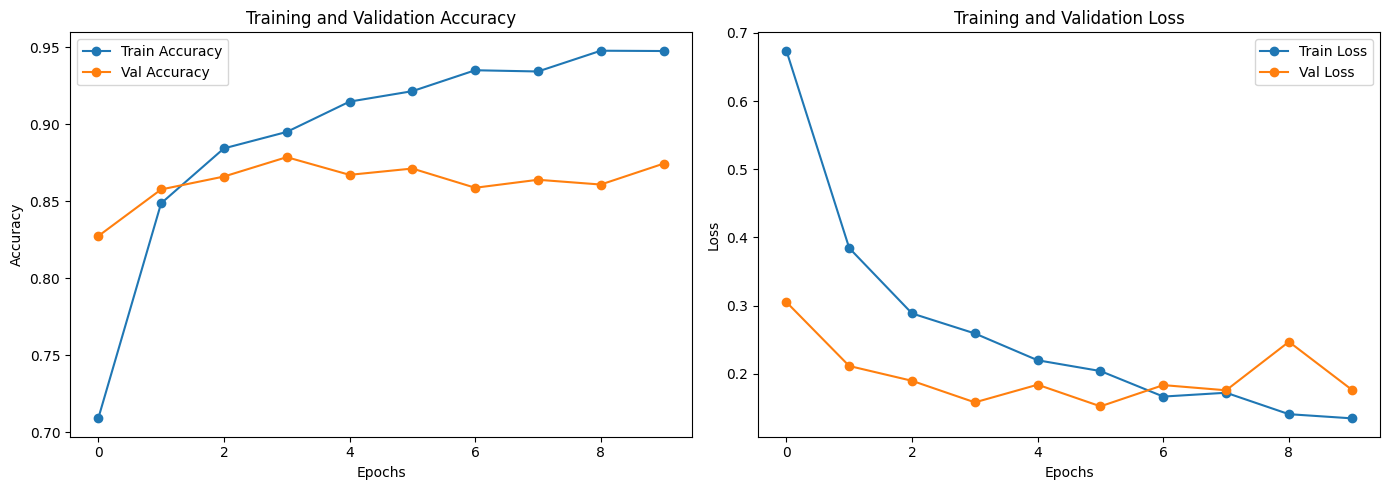

In [ ]:
epochs = list(range(10))
train_loss = [0.6737, 0.3845, 0.2887, 0.2594, 0.2201, 0.2043, 0.1669, 0.1725, 0.1411, 0.1350]
train_acc = [0.7089, 0.8487, 0.8844, 0.8951, 0.9148, 0.9216, 0.9352, 0.9344, 0.9479, 0.9477]
val_loss = [0.3053, 0.2117, 0.1900, 0.1584, 0.1843, 0.1526, 0.1837, 0.1761, 0.2472, 0.1770]
val_acc = [0.8274, 0.8577, 0.8661, 0.8787, 0.8672, 0.8713, 0.8588, 0.8640, 0.8609, 0.8745]


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Val Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/MViT/new_model.pth')

In [ ]:

# Evaluate the trained model on the test set

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.max(outputs, 1)[1]
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Compute Evaluation Metrics and confusion matrix

test_acc = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_acc:.4f}')

f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1 Score: {f1:.4f}')


class_report = classification_report(all_labels, all_preds, target_names=['Normal', 'Non-COVID', 'COVID'])
print('Classification Report:')
print(class_report)

conf_matrix = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Non-COVID', 'COVID'], yticklabels=['Normal', 'Non-COVID', 'COVID'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


<pre>
Test Accuracy: 0.9358
F1 Score: 0.9360
Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97       423
   Non-COVID       0.90      0.96      0.93       398
       COVID       0.91      0.89      0.90       331

    accuracy                           0.94      1152
   macro avg       0.93      0.93      0.93      1152
weighted avg       0.94      0.94      0.94      1152

</pre>

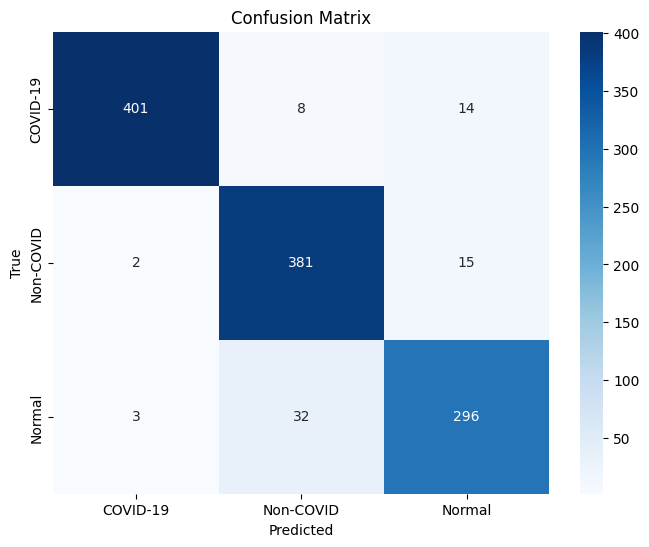

In [ ]:
conf_matrix = [[401, 8, 14],
               [2, 381, 15],
               [3, 32, 296]]

class_names = ['COVID-19', 'Non-COVID', 'Normal']


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()